Loaded image features: (908, 768)

>>> Image SOM (CLIP) Training <<<

SOM training took: 0.124230 seconds.
Epoch  1 → QE=0.4998, TE=0.1586
SOM training took: 0.118838 seconds.
Epoch  2 → QE=0.4963, TE=0.1211
SOM training took: 0.114937 seconds.
Epoch  3 → QE=0.4999, TE=0.1465
SOM training took: 0.121854 seconds.
Epoch  4 → QE=0.4984, TE=0.1674
SOM training took: 0.118542 seconds.
Epoch  5 → QE=0.4959, TE=0.1795
SOM training took: 0.117681 seconds.
Epoch  6 → QE=0.5008, TE=0.1399
SOM training took: 0.118464 seconds.
Epoch  7 → QE=0.4988, TE=0.1619
SOM training took: 0.116997 seconds.
Epoch  8 → QE=0.5017, TE=0.1564
SOM training took: 0.116808 seconds.
Epoch  9 → QE=0.4972, TE=0.1465
SOM training took: 0.119147 seconds.
Epoch 10 → QE=0.5002, TE=0.1795
SOM training took: 0.116665 seconds.
Epoch 11 → QE=0.5012, TE=0.1355
SOM training took: 0.119358 seconds.
Epoch 12 → QE=0.4996, TE=0.1377
SOM training took: 0.118158 seconds.
Epoch 13 → QE=0.4990, TE=0.1531
SOM training took: 0.118406 secon

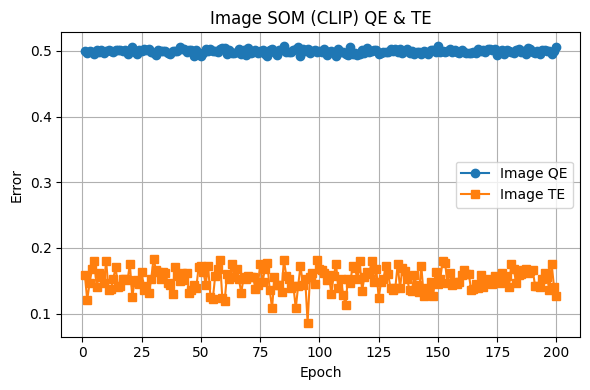

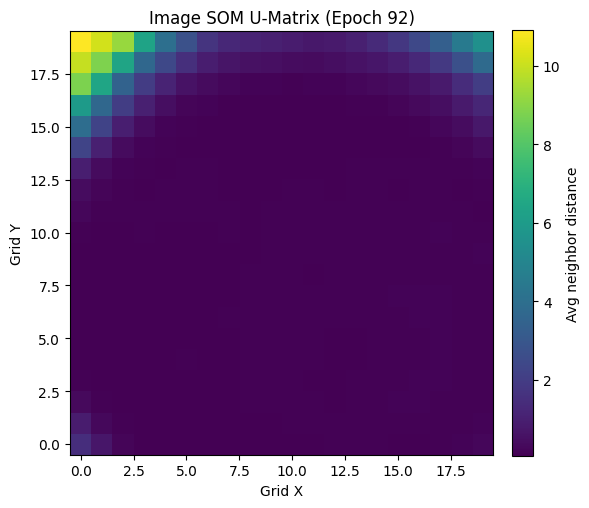

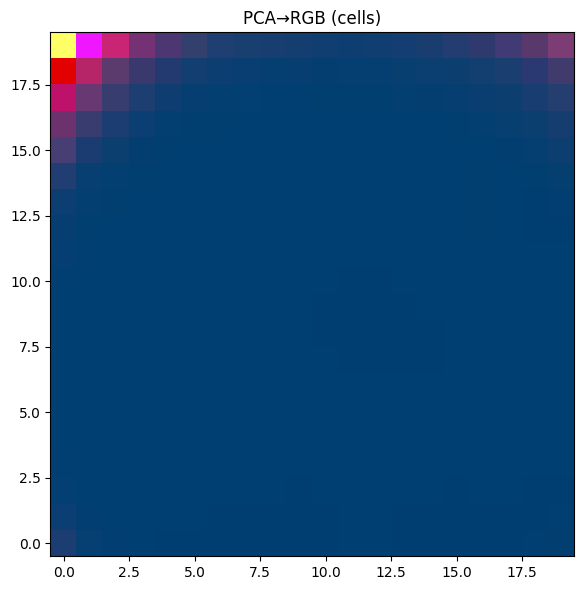

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.02206066377120415..1.1343916934718188].


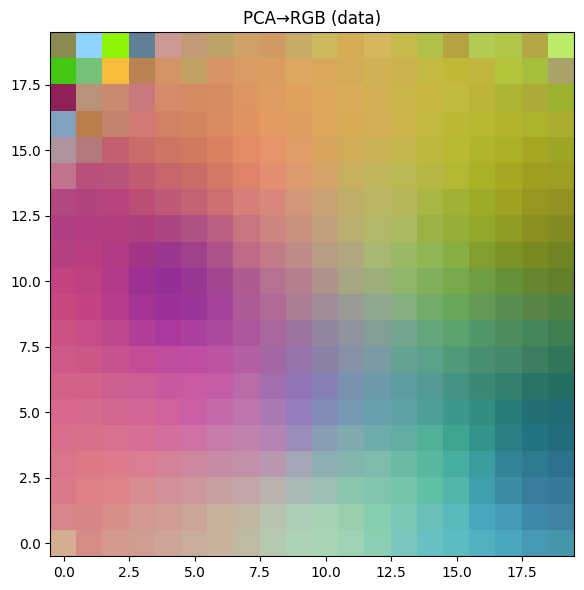

Best Image SOM epoch: 92, weights saved.


In [ ]:
import numpy as np
import pickle
from numbasom import SOM
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


X_img = np.load(r"C:\Users\golds\Desktop\Vectorial Encodings\Xadded_img_clip.npy")
print("Loaded image features:", X_img.shape)


def train_som_with_metrics(X, grid_size=(20,20), epochs=200, label="Image SOM"):
    som = SOM(som_size=grid_size, is_torus=False)
    qe_list, te_list, snapshots = [], [], []
    gx, gy = grid_size
    print(f"\n>>> {label} Training <<<\n")
    for epoch in range(epochs):
        lattice = som.train(X, num_iterations=X.shape[0])
        flat = lattice.reshape(-1, lattice.shape[2])
        # Quantization Error
        dists = [np.min(np.linalg.norm(flat - v, axis=1)) for v in X]
        qe = float(np.mean(dists))
        qe_list.append(qe)
        # Topographic Error
        te_count = 0
        for v in X:
            d2 = np.sum((flat - v)**2, axis=1)
            wids = np.argsort(d2)[:2]
            c1, c2 = divmod(wids[0], gy), divmod(wids[1], gy)
            if abs(c1[0] - c2[0]) + abs(c1[1] - c2[1]) > 1:
                te_count += 1
        te = te_count / len(X)
        te_list.append(te)
        snapshots.append(lattice.copy())
        print(f"Epoch {epoch+1:2d} → QE={qe:.4f}, TE={te:.4f}")
    print(f"\n>>> {label} Training End <<<\n")
    return qe_list, te_list, snapshots


qe_img, te_img, snap_img = train_som_with_metrics(X_img, grid_size=(20,20), epochs=200, label="Image SOM (CLIP)")


epochs = np.arange(1, len(qe_img) + 1)
plt.figure(figsize=(6,4))
plt.plot(epochs, qe_img, label='Image QE', marker='o')
plt.plot(epochs, te_img, label='Image TE', marker='s')
plt.xlabel('Epoch'); plt.ylabel('Error')
plt.title('Image SOM (CLIP) QE & TE')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

best_epoch = int(np.argmin(qe_img))
best_weights = snap_img[best_epoch]


gx, gy, dim = best_weights.shape
u = np.zeros((gx, gy))
for i in range(gx):
    for j in range(gy):
        neigh = []
        for di, dj in [(-1,0),(1,0),(0,-1),(0,1)]:
            ni, nj = i+di, j+dj
            if 0 <= ni < gx and 0 <= nj < gy:
                neigh.append(np.linalg.norm(best_weights[i,j] - best_weights[ni,nj]))
        u[i,j] = np.mean(neigh)


plt.figure(figsize=(6,6))
im = plt.imshow(u, origin='lower', cmap='viridis')
plt.scatter([],[])  # placeholder
plt.title(f'Image SOM U-Matrix (Epoch {best_epoch+1})')
plt.xlabel('Grid X'); plt.ylabel('Grid Y')
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('Avg neighbor distance')
plt.tight_layout(); plt.show()


flat = best_weights.reshape(-1, dim)


pca_cells = PCA(n_components=3).fit(flat)
comps_cells = pca_cells.transform(flat)
mins, maxs = comps_cells.min(0), comps_cells.max(0)
rgb_cells = ((comps_cells - mins) / (maxs - mins)).reshape(gx, gy, 3)
plt.figure(figsize=(6,6))
plt.imshow(rgb_cells, origin='lower')
plt.title('PCA→RGB (cells)')
plt.tight_layout(); plt.show()

pca_data = PCA(n_components=3).fit(X_img)
comps_data = pca_data.transform(flat)
dmins, dmaxs = pca_data.transform(X_img).min(0), pca_data.transform(X_img).max(0)
rgb_data = ((comps_data - dmins) / (dmaxs - dmins)).reshape(gx, gy, 3)
plt.figure(figsize=(6,6))
plt.imshow(rgb_data, origin='lower')
plt.title('PCA→RGB (data)')
plt.tight_layout(); plt.show()

pickle.dump(best_weights, open(r'C:\Users\golds\Desktop\Vectorial Encodings\som_image_clip_best.pkl', 'wb'))
print(f"Best Image SOM epoch: {best_epoch+1}, weights saved.")
